In [1]:
from tqdm import tqdm

import glob
import ntpath
import cv2

from sklearn.metrics.pairwise import cosine_similarity
import scipy as sc
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model

import io
import bson
import matplotlib.pyplot as plt
from skimage.io import imread   # or, whatever image library you prefer
import multiprocessing as mp      # will come in handy due to the size of the data
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip '/content/drive/MyDrive/ADM_Assignment/Assignment_3/Dataset.zip' -d '/content/images/'

Streaming output truncated to the last 5000 lines.
  inflating: /content/images/Dataset/1000012591_395792_2.jpeg  
  inflating: /content/images/__MACOSX/Dataset/._1000012591_395792_2.jpeg  
  inflating: /content/images/Dataset/1000015780_227224_1.jpeg  
  inflating: /content/images/__MACOSX/Dataset/._1000015780_227224_1.jpeg  
  inflating: /content/images/Dataset/1000006354_226136_2.jpeg  
  inflating: /content/images/__MACOSX/Dataset/._1000006354_226136_2.jpeg  
  inflating: /content/images/Dataset/1000005296_1257573_1.jpeg  
  inflating: /content/images/__MACOSX/Dataset/._1000005296_1257573_1.jpeg  
  inflating: /content/images/Dataset/1000009561_1748445_1.jpeg  
  inflating: /content/images/__MACOSX/Dataset/._1000009561_1748445_1.jpeg  
  inflating: /content/images/Dataset/1000011715_1200098_1.jpeg  
  inflating: /content/images/__MACOSX/Dataset/._1000011715_1200098_1.jpeg  
  inflating: /content/images/Dataset/1000019295_2837375_1.jpeg  
  inflating: /content/images/__MACOSX/Datase

In [4]:
import glob
image_paths = glob.glob('/content/images/Dataset/*.jpeg')

In [5]:
images = {}
for image_path in image_paths:
    image = cv2.imread(image_path, 3)
    b,g,r = cv2.split(image)           # Splitting the RGB Channels of the image
    image = cv2.merge([r,g,b]) 
    image = cv2.resize(image, (200, 200))
    images[ntpath.basename(image_path)] = image   

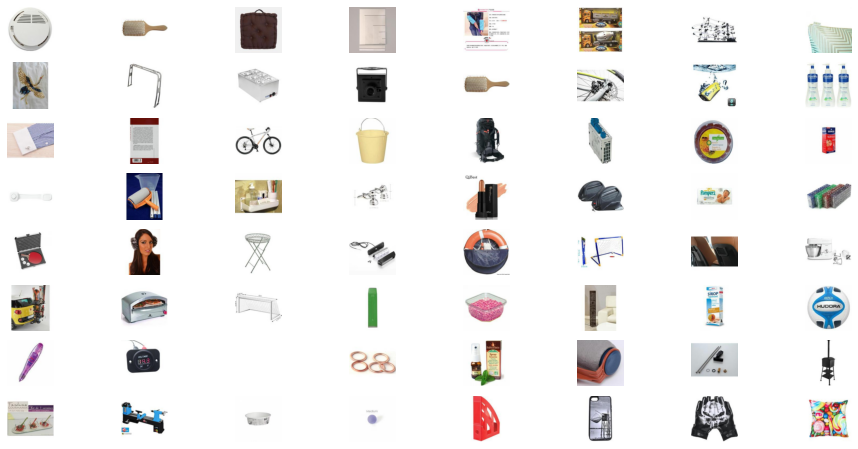

In [6]:
n_col = 8
n_row = 8
f, ax = plt.subplots(n_row, n_col, figsize=(16, 8))
for i in range(n_row):
    for j in range(n_col):
        ax[i, j].imshow(list(images.values())[n_col*i + j])
        ax[i, j].set_axis_off()

In [7]:
def load_image(image):
    image = plt.imread(image)
    img = tf.image.convert_image_dtype(image, tf.float32)
    img = tf.image.resize(img, [400, 400])
    img = img[tf.newaxis, :] # shape -> (batch_size, h, w, d)
    return img

# content layers describe the image subject
content_layers = ['block5_conv2'] 

# style layers describe the image style
# we exclude the upper level layes to focus on small-size style details
style_layers = [ 
        'block1_conv1',
        'block2_conv1',
        'block3_conv1', 
        #'block4_conv1', 
        #'block5_conv1'
    ] 

def selected_layers_model(layer_names, baseline_model):
    outputs = [baseline_model.get_layer(name).output for name in layer_names]
    model = Model([vgg.input], outputs)
    return model

# style embedding is computed as concatenation of gram matrices of the style layers
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

class StyleModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleModel, self).__init__()
        self.vgg =  selected_layers_model(style_layers + content_layers, vgg)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        # scale back the pixel values
        inputs = inputs*255.0
        # preprocess them with respect to VGG19 stats
        preprocessed_input = preprocess_input(inputs)
        # pass through the reduced network
        outputs = self.vgg(preprocessed_input)
        # segregate the style and content representations
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        # calculate the gram matrix for each layer
        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        # assign the content representation and gram matrix in
        # a layer by layer fashion in dicts
        content_dict = {content_name:value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}

vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

def image_to_style(image_tensor):
    extractor = StyleModel(style_layers, content_layers)
    return extractor(image_tensor)['style']

def style_to_vec(style):
    # concatenate gram matrics in a flat vector
    return np.hstack([np.ravel(s) for s in style.values()]) 
    
# compute styles
image_style_embeddings = {}
for image_path in tqdm(image_paths): 
    image_tensor = load_image(image_path)
    style = style_to_vec( image_to_style(image_tensor) )
    image_style_embeddings[ntpath.basename(image_path)] = style

80142336/80134624 [==============================] - 0s 0us/step


100%|██████████| 9191/9191 [06:46<00:00, 22.59it/s]


In [8]:
def search_by_style_display(reference_image, max_results=10):
    v0 = image_style_embeddings[reference_image]
    distances = {}
    for k,v in image_style_embeddings.items():
        d = sc.spatial.distance.cosine(v0, v)
        distances[k] = d

    sorted_neighbors = sorted(distances.items(), key=lambda x: x[1], reverse=False)
    
    f, ax = plt.subplots(1, max_results, figsize=(16, 8))
    for i, img in enumerate(sorted_neighbors[:max_results]):
        ax[i].imshow(images[img[0]])
        ax[i].set_axis_off()
    
    plt.show()

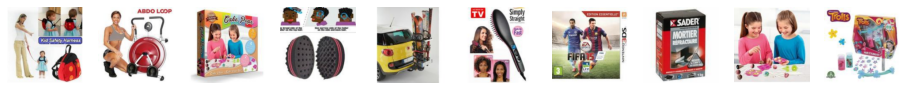

In [9]:
search_by_style_display('1000000461_643280_1.jpeg')

In [10]:
def search_by_style(reference_image, max_results=10):
    v0 = image_style_embeddings[reference_image]
    distances = {}
    for k,v in image_style_embeddings.items():
        d = sc.spatial.distance.cosine(v0, v)
        distances[k] = d

    sorted_neighbors = sorted(distances.items(), key=lambda x: x[1], reverse=False)
    return sorted_neighbors[:11]


In [11]:
search_by_style('1000001589_411648_2.jpeg')

[('1000001589_411648_2.jpeg', 0.0),
 ('1000001589_240678_1.jpeg', 0.020602643489837646),
 ('1000001589_240678_2.jpeg', 0.022059917449951172),
 ('1000007158_92955_1.jpeg', 0.022852182388305664),
 ('1000010562_212334_1.jpeg', 0.023945927619934082),
 ('1000010562_146981_4.jpeg', 0.02475416660308838),
 ('1000010562_254047_1.jpeg', 0.02521800994873047),
 ('1000010562_146981_1.jpeg', 0.026317059993743896),
 ('1000010562_168146_3.jpeg', 0.026553630828857422),
 ('1000001589_682921_1.jpeg', 0.027029097080230713),
 ('1000001589_665834_3.jpeg', 0.028244435787200928)]

In [12]:
x = []
for image_name in tqdm(images.keys()):
    z = search_by_style(image_name)
    x.append(z)
    #print(len(x))
    if len(x) == 500:
      break


  5%|▌         | 499/9191 [27:50<8:09:27,  3.38s/it]

In [13]:
y = pd.DataFrame(x)
y

,0,1,2,3,4,5,6,7,8,9,10
0,"(1000015643_6616037_4.jpeg, 0.0)","(1000003633_1196991_1.jpeg, 0.03655010461807251)","(1000003633_1681813_1.jpeg, 0.03956937789916992)","(1000003633_667873_1.jpeg, 0.04153943061828613)","(1000002619_86025_4.jpeg, 0.04638272523880005)","(1000005352_4064613_4.jpeg, 0.047364652156829834)","(1000003633_1220595_1.jpeg, 0.048323869705200195)","(1000013443_914764_2.jpeg, 0.04906731843948364)","(1000003633_720793_1.jpeg, 0.05028557777404785)","(1000010410_84830_1.jpeg, 0.05186653137207031)","(1000005736_778666_1.jpeg, 0.0524219274520874)"
1,"(1000016910_1688182_2.jpeg, 0.0)","(1000016910_1136741_2.jpeg, 0.0)","(1000019142_1254327_1.jpeg, 0.004057526588439941)","(1000004298_114839_1.jpeg, 0.005353987216949463)","(1000020743_5663677_1.jpeg, 0.0053997039794921...","(1000004298_26489_0.jpeg, 0.0057801008224487305)","(1000004298_124416_1.jpeg, 0.005791664123535156)","(1000019142_216149_1.jpeg, 0.005874693393707275)","(1000016282_1588895_3.jpeg, 0.005924522876739502)","(1000016282_1588895_1.jpeg, 0.005924522876739502)","(1000016282_1588895_2.jpeg, 0.005924522876739502)"
2,"(1000001703_17388_2.jpeg, 0.0)","(1000007158_140139_3.jpeg, 0.014980792999267578)","(1000006551_6063625_1.jpeg, 0.016907215118408203)","(1000006551_6063625_2.jpeg, 0.016907215118408203)","(1000007158_216766_1.jpeg, 0.017535746097564697)","(1000007158_216766_4.jpeg, 0.017535746097564697)","(1000007158_129363_1.jpeg, 0.018921077251434326)","(1000018606_481466_1.jpeg, 0.01989036798477173)","(1000019645_123235_4.jpeg, 0.020013511180877686)","(1000019645_123235_3.jpeg, 0.02021414041519165)","(1000010562_246988_1.jpeg, 0.020495057106018066)"
3,"(1000014621_1963541_1.jpeg, 0.0)","(1000014621_1963541_3.jpeg, 0.0)","(1000014621_1963541_2.jpeg, 0.007210373878479004)","(1000014621_2716401_3.jpeg, 0.00804835557937622)","(1000014621_2716401_1.jpeg, 0.00804835557937622)","(1000014621_2716401_2.jpeg, 0.009959757328033447)","(1000015780_280321_2.jpeg, 0.039496660232543945)","(1000002553_135503_1.jpeg, 0.039967477321624756)","(1000020717_296352_3.jpeg, 0.04174572229385376)","(1000015780_280321_3.jpeg, 0.04202967882156372)","(1000011715_1613416_2.jpeg, 0.04536163806915283)"
4,"(1000017746_1267537_3.jpeg, 0.0)","(1000016910_453804_4.jpeg, 0.044327497482299805)","(1000016910_2709133_2.jpeg, 0.04496818780899048)","(1000016591_4137670_1.jpeg, 0.04655641317367554)","(1000018657_218183_2.jpeg, 0.04728996753692627)","(1000000461_1477576_2.jpeg, 0.04859113693237305)","(1000004450_440670_1.jpeg, 0.04897129535675049)","(1000006450_381861_4.jpeg, 0.0507657527923584)","(1000016486_152523_1.jpeg, 0.05089181661605835)","(1000008761_502251_3.jpeg, 0.0513763427734375)","(1000007560_1453347_1.jpeg, 0.05268067121505737)"
...,...,...,...,...,...,...,...,...,...,...,...
495,"(1000016486_171143_1.jpeg, 0.0)","(1000016486_105489_1.jpeg, 0.0007423758506774902)","(1000016486_141945_1.jpeg, 0.0007460713386535645)","(1000016486_263666_1.jpeg, 0.0008301138877868652)","(1000016486_207551_1.jpeg, 0.00118255615234375)","(1000016486_151564_1.jpeg, 0.0012278556823730469)","(1000016486_257542_1.jpeg, 0.0012513399124145508)","(1000016486_290129_1.jpeg, 0.001370847225189209)","(1000016486_290001_1.jpeg, 0.0015460848808288574)","(1000016486_269313_1.jpeg, 0.0018153786659240723)","(1000018433_760997_3.jpeg, 0.044047653675079346)"
496,"(1000001703_54834_2.jpeg, 0.0)","(1000008134_90636_2.jpeg, 0.01711869239807129)","(1000007158_114070_1.jpeg, 0.019511699676513672)","(1000002619_237593_2.jpeg, 0.01995784044265747)","(1000004450_354289_1.jpeg, 0.020871341228485107)","(1000001857_131598_1.jpeg, 0.021510064601898193)","(1000020717_1077302_1.jpeg, 0.021678626537322998)","(1000000489_1424035_1.jpeg, 0.021884441375732422)","(1000008134_94380_1.jpeg, 0.02189314365386963)","(1000001857_86834_1.jpeg, 0.021983742713928223)","(1000002553_114226_2.jpeg, 0.02296227216720581)"
497,"(1000016591_5259729_1.jpeg, 0.0)","(1000008611_1188302_1.jpeg, 0.03921133279800415)","(1000017306_1471442_1.jpeg, 0.04078418016433716)"

In [14]:
def test(neigh):
  return neigh[0]

In [15]:
z = y.applymap(test)


In [16]:
z

,0,1,2,3,4,5,6,7,8,9,10
0,1000015643_6616037_4.jpeg,1000003633_1196991_1.jpeg,1000003633_1681813_1.jpeg,1000003633_667873_1.jpeg,1000002619_86025_4.jpeg,1000005352_4064613_4.jpeg,1000003633_1220595_1.jpeg,1000013443_914764_2.jpeg,1000003633_720793_1.jpeg,1000010410_84830_1.jpeg,1000005736_778666_1.jpeg
1,1000016910_1688182_2.jpeg,1000016910_1136741_2.jpeg,1000019142_1254327_1.jpeg,1000004298_114839_1.jpeg,1000020743_5663677_1.jpeg,1000004298_26489_0.jpeg,1000004298_124416_1.jpeg,1000019142_216149_1.jpeg,1000016282_1588895_3.jpeg,1000016282_1588895_1.jpeg,1000016282_1588895_2.jpeg
2,1000001703_17388_2.jpeg,1000007158_140139_3.jpeg,1000006551_6063625_1.jpeg,1000006551_6063625_2.jpeg,1000007158_216766_1.jpeg,1000007158_216766_4.jpeg,1000007158_129363_1.jpeg,1000018606_481466_1.jpeg,1000019645_123235_4.jpeg,1000019645_123235_3.jpeg,1000010562_246988_1.jpeg
3,1000014621_1963541_1.jpeg,1000014621_1963541_3.jpeg,1000014621_1963541_2.jpeg,1000014621_2716401_3.jpeg,1000014621_2716401_1.jpeg,1000014621_2716401_2.jpeg,1000015780_280321_2.jpeg,1000002553_135503_1.jpeg,1000020717_296352_3.jpeg,1000015780_280321_3.jpeg,1000011715_1613416_2.jpeg
4,1000017746_1267537_3.jpeg,1000016910_453804_4.jpeg,1000016910_2709133_2.jpeg,1000016591_4137670_1.jpeg,1000018657_218183_2.jpeg,1000000461_1477576_2.jpeg,1000004450_440670_1.jpeg,1000006450_381861_4.jpeg,1000016486_152523_1.jpeg,1000008761_502251_3.jpeg,1000007560_1453347_1.jpeg
...,...,...,...,...,...,...,...,...,...,...,...
495,1000016486_171143_1.jpeg,1000016486_105489_1.jpeg,1000016486_141945_1.jpeg,1000016486_263666_1.jpeg,1000016486_207551_1.jpeg,1000016486_151564_1.jpeg,1000016486_257542_1.jpeg,1000016486_290129_1.jpeg,1000016486_290001_1.jpeg,1000016486_269313_1.jpeg,1000018433_760997_3.jpeg
496,1000001703_54834_2.jpeg,1000008134_90636_2.jpeg,1000007158_114070_1.jpeg,1000002619_237593_2.jpeg,1000004450_354289_1.jpeg,1000001857_131598_1.jpeg,1000020717_1077302_1.jpeg,1000000489_1424035_1.jpeg,1000008134_94380_1.jpeg,1000001857_86834_1.jpeg,1000002553_114226_2.jpeg
497,1000016591_5259729_1.jpeg,1000008611_1188302_1.jpeg,1000017306_1471442_1.jpeg,1000004309_426089_2.jpeg,1000020751_7039380_1.jpeg,1000018657_2659678_1.jpeg,1000017306_701774_3.jpeg,1000018657_2659678_3.jpeg,1000000489_1492319_4.jpeg,1000008611_2458205_1.jpeg,1000016591_5259729_3.jpeg
498,1000016486_244136_1.jpeg,1000016486_98697_1.jpeg,1000016486_98843_1.jpeg,1000016486_57884_1.jpeg,1000016486_67206_1.jpeg,1000016486_218962_1.jpeg,1000016486_146717_1.jpeg,1000016486_26652_1.jpeg,1000016486_12881_1.jpeg,1000016486_237439_1.jpeg,1000016486_242239_1.jpeg


In [17]:
z.to_csv('Artistic.csv')